In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd
from llavart.utils.dirutils import get_data_dir, get_store_dir, get_model_checkpoints_dir
from llavart.models.retriever.modeling import MultiModalSentEmbedder
from llavart.data.datasets.image_text_dataset import ImageTextDataset
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import chromadb
import torch
from transformers import CLIPProcessor
import lovely_tensors as lt
from accelerate import Accelerator
import os
from PIL import Image
import glob

lt.monkey_patch()

/home/nicola/miniconda3/envs/vitart/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
chroma_client = chromadb.PersistentClient(str(get_store_dir()))
collection = chroma_client.get_collection(os.getenv("TEXT_FEATURES_COLLECTION_NAME"))
collection

Collection(name=text_features)

In [4]:
res = collection.peek(limit=10)

In [5]:
res["documents"]

['The visual arts are art forms such as painting, drawing, printmaking, sculpture, ceramics, photography, video, filmmaking, design, crafts, and architecture. Many artistic disciplines, such as performing arts, conceptual art, and textile arts, also involve aspects of the visual arts as well as arts of other types. Also included within the visual arts are the applied arts, such as industrial design, graphic design, fashion design, interior design, and decorative art.',
 'Current usage of the term "visual arts" includes fine art as well as applied or decorative arts and crafts, but this was not always the case. Before the Arts and Crafts Movement in Britain and elsewhere at the turn of the 20th century, the term \'artist\' had for some centuries often been restricted to a person working in the fine arts (such as painting, sculpture, or printmaking) and not the decorative arts, crafts, or applied visual arts media. The distinction was emphasized by artists of the Arts and Crafts Movement

In [6]:
model = MultiModalSentEmbedder("sentence-transformers/all-MiniLM-L12-v2", "openai/clip-vit-base-patch32", clip_dtype=torch.float32)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

/home/nicola/miniconda3/envs/vitart/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


MultiModalSentEmbedder(
  (clip_model): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_features=512

In [7]:
accelerator = Accelerator()
transform = Compose([Resize(224), CenterCrop(224), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [8]:
dataset = ImageTextDataset(
    get_data_dir() / "texts" / "wiki_img_paragraph_clean.csv",
    get_data_dir() / "wikipedia_images",
    split="val",
    transform=transform,
)

In [9]:
state_dict = {}
# load all pytorch_model*.bin files into the state dict
for file in glob.glob(str(get_model_checkpoints_dir() / "retriever" / "frosty-armadillo-2" / "best" / "pytorch_model*.bin")):
    state_dict.update(torch.load(file))
model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['temperature'])

In [10]:
samples = []
for i in range(50, 100):
    sample = dataset[i]
    samples.append(sample)

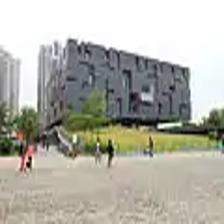

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.155, 0.161] μ=0.000 σ=0.051 cuda:0
Results: [['The Science Collaboration Centre is a six storey, multi-use building that will act as the heart of the campus. Its projected completion date is Spring 2023 with a budget of $62 million dollars. The building will feature three open plan studios, offices, laboratories, and data storage. The facade design is mostly glass which will reveal the active spaces inside as well as the wood structure.', "In January 2019 the University announced a competition for architects to transform the site to provide accommodation, study spaces and communal social areas for 400 resident students with an aim to complete the project by 2022. Estimated fees for the project were set at Â£4 million. The competition also invited architects to bid for work on the main Highfield Campus as part of the institution's 10-year estates development programme. Entries for the competition closed in February 2019 and it was reported in

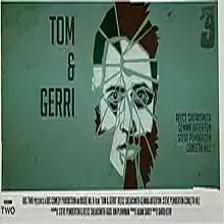

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.152, 0.140] μ=0.002 σ=0.051 cuda:0
Results: [["As of 1 April 1950 the film earned distributor's gross receipts of Â£47,282 in the UK of which Â£17,678 went to the producer.", "As of 1 April 1950 the film earned distributor's gross receipts of Â£147,124 in the UK of which Â£94,902 went to the producer.", 'According to Variety the film was the 37th most popular movie in the US and Canada in 1949 earning $2.1 million. It earned $1.7 million the following year.', 'As of 30 June 1949 the film earned Â£166,075 in the UK of which Â£111,820 went to the producer.', 'As of 30 June 1949 the film earned Â£203,000 in the UK of which Â£150,553 went to the producer.', 'As of 30 June 1949 the film earned Â£45,713 in the UK of which Â£33,401 went to the producer.', 'As of 30 June 1949 the film earned Â£129,700 in the UK of which Â£84,073 went to the producer.', "The film generated producer's receipts amounting to Â£186,500 within the United Kingd

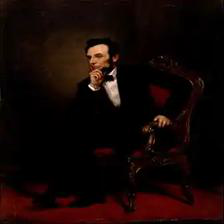

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.186, 0.131] μ=0.001 σ=0.051 cuda:0
Results: [['"I didn\'t just want to make a photograph with some things in the background," Newman told American Photo magazine in an interview. "The surroundings had to add to the composition and the understanding of the person. No matter who the subject was, it had to be an interesting photograph. Just to simply do a portrait of a famous person doesn\'t mean a thing."', 'Henry Grossman (October 11, 1936 â\x80\x93 November 27, 2022) was an American photographer, best known for his portraits of notable figures, in particular President John F. Kennedy and The Beatles, as well as prominent political figures, writers, and performing artists. Through much of his career he was a staff photographer for Life magazine. His photographs feature portraits that include Lyndon Johnson, Richard Nixon, Kurt Vonnegut Jr, Elizabeth Taylor, Richard Burton, Luciano Pavarotti, and Barbra Streisand.', 'Newman found his vision in

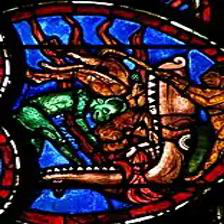

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.150, 0.140] μ=-0.000 σ=0.051 cuda:0
Results: [['Stained glass became a significant art-form in the period, though little Romanesque glass survives. In illuminated manuscripts the bible became a new focus of intensive decoration, with the psalter also remaining important. The strong emphasis on the suffering of Christ and other sacred figures entered Western art in this period, a feature that strongly distinguishes it from both Byzantine and classical art for the remainder of the Middle Ages and beyond. The Gero Cross of 965-970, at the cusp of Ottonian and Romanesque art, has been called the first work to exhibit this. The end of the Romanesque period saw the start of the greatly increased emphasis on the Virgin Mary in theology, literature and so also art that was to reach its full extent in the Gothic period.', 'The Holy Spirit is represented in various artistic mediums such as stained glass windows and calligraphy.', 'In the Early Gothic p

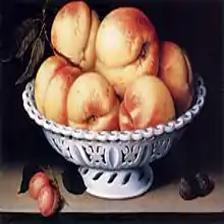

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.156, 0.162] μ=0.001 σ=0.051 cuda:0
Results: [["7. Flavors First: An Indian Chef's Culinary Journey", 'She enjoyed hosting large dinner parties and giving lectures that educated culinary history and recreated past historical cuisines. This included a college lecture that had an entire wild boar roasted in an oven to mimic a Roman feast, and a lecture on the use of marijuana in cooking used during the Italian Renaissance. In her book, Art, Culture, and Cuisine: Ancient and Medieval Gastronomy (1999) she explored prehistoric recipes, alongside reflections of art history and archaeology.', 'The plant can further be prepared in several ways â\x80\x93 cooked, steamed, or stir fried â\x80\x93 and eaten as a vegetable dish.', 'In the Netherlands, chocoladehagelslag (chocolate sprinkles) is used as a sandwich topping (similar to muisjes and vlokken); this is also common in Belgium and the former colonies of the Netherlands, Suriname and Indonesia. T

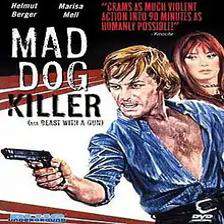

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.156, 0.193] μ=0.000 σ=0.051 cuda:0
Results: [['Lethal Weapon is an American buddy cop action-comedy media franchise created by Shane Black. It focuses on two Los Angeles Police Department (LAPD) detectives, Martin Riggs and Roger Murtaugh. The franchise consists of a series of four films released between 1987 and 1998 and a television series which aired from 2016 to 2019. The four films were directed by Richard Donner and also share many of the same core cast members, while the television series is a reboot with different actors. Although the first film was not explicitly a comedy, the later films and the television series gradually became comedic in nature.', 'Lethal Weapon is a 1987 American buddy cop action-comedy film directed and co-produced by Richard Donner, written by Shane Black, and co-produced by Joel Silver. It stars Mel Gibson and Danny Glover alongside Gary Busey, Tom Atkins, Darlene Love, and Mitchell Ryan.', 'Lethal Weapon is 

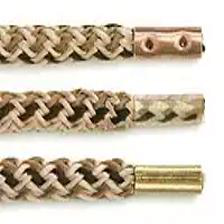

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.153, 0.152] μ=0.001 σ=0.051 cuda:0
Results: [['The most common cable tie consists of a flexible nylon tape with an integrated linear ratchet gear rack, and on one end a pawl within a small open case. Once the pointed tip of the cable tie has been pulled through the case and past the ratchet, it is prevented from being pulled back unless a large amount of force is applied; the resulting loop may only be pulled tighter. This allows several cables to be bound together into a cable bundle and/or to form a cable tree.', 'The common cable tie, normally made of nylon, has a flexible tape section with teeth that engage with a pawl in the head to form a ratchet so that as the free end of the tape section is pulled the cable tie tightens and does not come undone. When the mouthpiece is inserted through the grooves and pulled tight, it creates a secure, adjustable loop, which locks in place like a knot. Some ties include a tab that can be depressed to r

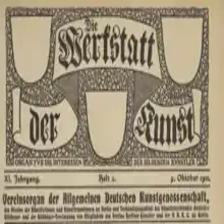

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.134, 0.140] μ=0.001 σ=0.051 cuda:0
Results: [['About the time of his election to the Reichstag, Stinnes began to buy up leading German newspapers, one of his main objects being to organize a solid and powerful bloc of opinion in Germany in support of law and order and the promotion of the highest industrial and commercial efficiency. His newspaper purchases included the Deutsche Allgemeine Zeitung in Berlin, formerly the organ of Otto von Bismarck and then of all the succeeding German governments, the MÃ1⁄4nchener Neueste Nachrichten and the MÃ1⁄4nchen-Augsburger Zeitung, the latter being one of the oldest newspapers in Germany. Both of the Munich journals were previously exponents of a very much more democratic trend of opinion than that which came to characterize them under his proprietorship. Ancillary to these acquisitions, Stinnes secured large interests in paper mills in order to make his newspapers independent of the paper market.', 

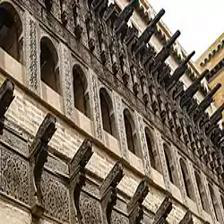

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.144, 0.237] μ=0.000 σ=0.051 cuda:0
Results: [['The film was shot in Rome and on location in Barcelona, Spain.', 'The interiors of the film were shot largely in Spain, with exteriors in Rome.', 'The film was shot at and is set in various locations around Barcelona.', 'The film features locations in Barcelona, including La Rambla in the opening images. Later, when Richard Greene follows the villains (both travelling in taxis), they get out in Plaza Real with its arcaded pavements.', 'Freda\'s film Maciste alla corte del Gran Khan was what was called a "film di recupero" in Italy, meaning a recovery film. The film was created in order to earn money from the expensive epic Marco Polo.', 'Director Vari filmed at CSC Studios. Rome Against Rome was the second last film by the production company Galatea studio and the film historian Tim Lucas described as representing the end of the peplum cycle as it was a "victim of the burgeoning "Spaghetti Wester

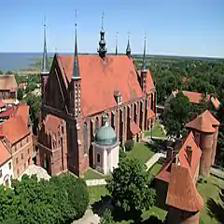

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.144, 0.225] μ=0.000 σ=0.051 cuda:0
Results: [["Much of the coast of the Baltic Sea in the period from the 12th century to 1637 belonged to the Griffins' Duchy of Pomerania. Nowadays its territory is divided into two partsâ\x80\x94middle and eastern in Poland and westernmost in Germany. The most outstanding Gothic monuments in this area are Romanesque-Gothic Cathedral of St. John the Baptist in KamieÅ\x84 Pomorski, Cistercian abbey in KoÅ\x82bacz, ruins of Jasienica Abbey in Police, ruins of Eldena Abbey (a Danish foundation) in Greifswald, St. Mary's Church in Usedom, Castle of the Pomeranian Dukes in DarÅ\x82owo, remnants of LÃ¶cknitz Castle, St. Nicholas collegial church in Greifswald, St. Nicholas' Church in Stralsund, St. Mary's Church in Stralsund, St. Mary and St. Nicholas churches in Anklam, St. Mary's Church in Stargard, St. Nicholas Church in Wolin, St. Peter's Church in Wolgast, Cathedral Basilica of St. James the Apostle in Sz

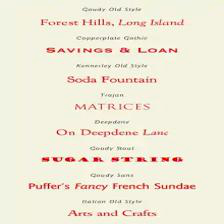

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.171, 0.156] μ=0.000 σ=0.051 cuda:0
Results: [['Betty Crocker products, owned by General Mills, had one of the best-known premium programs when the company started inserting coupons in bags of flour in 1929 which consumers could collect and use to purchase Oneida flatware at a reduced price. In 1932, the popular coupon program was improved so that consumers could redeem coupons for an entire set of flatware â\x80\x94 the pattern was called "Friendship". Beginning in 1937, the coupons were printed on the outside of the box with point values and could be redeemed through the Betty Crocker Catalog in exchange for cookbooks, kitchenwares, and home accessories, as the box tops stated, for 25 to 75 percent savings. To avoid confusion with cents-off coupons, the premium program was renamed "Betty Crocker Catalog Points" in 1992. General Mills retired the Betty Crocker Catalog in December 2006 and ended the premium program after 75 years. (Now that t

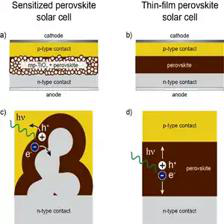

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.145, 0.161] μ=0.001 σ=0.051 cuda:0
Results: [['Gels consist of non-solvent-soluble 3D polymer scaffolds, which are covalently or physically cross-linked, that have a high-solvent content ratio. Research into functionalizing gels that are sensitive to mechanical and thermal stress, as well as solvent choice, have given rise to diverse structures with characteristics such as shape-memory, or the ability to bind guest molecules selectively and reversibly.', 'A method called gel network stabilization represents the principal way to produce colloids stable to both aggregation and sedimentation. The method consists in adding to the colloidal suspension a polymer able to form a gel network. Particle settling is hindered by the stiffness of the polymeric matrix where particles are trapped, and the long polymeric chains can provide a steric or electrosteric stabilization to dispersed particles. Examples of such substances are xanthan and guar gum.', '

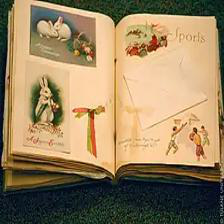

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.156, 0.170] μ=0.001 σ=0.051 cuda:0
Results: [["The term toy book originated in the 18th century when John Newbery began printing 'gift books'â\x80\x94such as A Little Pretty Pocket-Book (1744)â\x80\x94with small toys such as pincushions for girls included in the packaging. The earliest toy books were picture books bound in paper, of six to eight pages, often left blank on the back, with a small amount of text, and coloured illustrations rarely attributed to illustrators. The books were usually bound in heavy paper; some that were guaranteed to be indestructible were bound in linen and sold for a shilling. Toy books were often released as a series, and the most common subjects were popular rhymes and tales.", "Toy books were illustrated children's books that became popular in England's Victorian era. The earliest toy books were typically paperbound, with six illustrated pages and sold for sixpence; larger and more elaborate editions became p

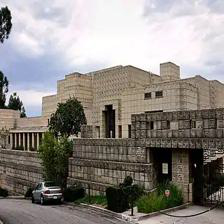

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.155, 0.215] μ=0.000 σ=0.051 cuda:0
Results: [['From 1965, the museum was housed in a series of masonry buildings designed by the Russian-born Israeli architect Alfred Mansfeld. A $100-million campaign to renovate the museum and double its gallery space was completed by Israeli architects Efrat-Kowalsky Architects who renovated the existing buildings in July 2010. The wings for archaeology, the fine arts, and Jewish art and life were completely rebuilt and the original buildings were linked through a new entrance pavilion. The passageways that connect between the buildings and five new pavilions were designed by James Carpenter.', 'While filming Mathaf al Iskandariya, a documentary about the Greco-Roman Museum in Alexandria, El Bakry filmed the recovery of what were thought to be remains of the Pharos of Alexandria. After finding that works to stabilize the adjacent Citadel of Qaitbay were destroying ancient artifacts, she went public with her

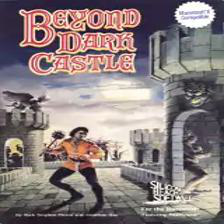

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.155, 0.144] μ=0.002 σ=0.051 cuda:0
Results: [['The game was conceived as a prequel to all other games in the Castlevania series; however, it later became recognized as non-canon. The story follows Sonia Belmont, a vampire hunter battling the first incarnation of Count Dracula.', "The franchise's first arcade game, Haunted Castle (1988), returned to the linear platforming gameplay of the original. This continued with the first handheld Game Boy entry, Castlevania: The Adventure and the NES sequel, Castlevania III: Dracula's Curse, both released in 1989. Dracula's Curse added features to the original gameplay, including alternate stages and multiple playable characters. The Adventure saw a Game Boy sequel, Castlevania II: Belmont's Revenge, in 1992 and a remake, Castlevania: The Adventure ReBirth, developed by M2 for the WiiWare service in 2009.", "Castlevania II: Belmont's Revenge[lower-alpha 1] is a platform game released for the Game Boy in 

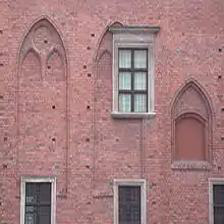

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.146, 0.270] μ=0.000 σ=0.051 cuda:0
Results: [["The building is notable in that it is reminiscent of Milan's Royal Villa and of country houses in general as the main body of the building is set back to form a courtyard next to the street. The entrance consists of an Ionic colonnade supporting a parapet. The two lateral sections have giant pilasters surmounted by triangular tympani.", 'The medieval walls of Milan were constructed after multiple disasters had devastated Milan, including 11th-century urban fires and a highly destructive sack by the emperor Barbarossa in 1162. This postern was one of the ten secondary gates and until the 1930s, its outer face was near the bank of a navigli (canal), which ran along the present via Carducci.', 'Probably the finest example of Italian Gothic architecture is the huge Milan Cathedral is famous for its medieval spires, impressive facade, grand bronze-doors, and the Madonnina golden statue at the top, whi

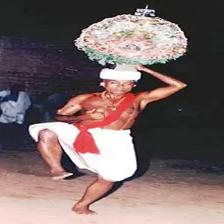

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.181, 0.137] μ=0.001 σ=0.051 cuda:0
Results: [['Their traditional festivals are Asari, Nawakhani, Karam, Surjahi Puja, Jitia, Sohrai, Sarhul, Fagun etc. Their folk dance are Jhumair, Domkach, Fagua etc.', 'The Limbu (Yakthung) have various forms of songs, dances and musical instruments. Of them, Dhan Naach (paddy dance) and Chyabrung (Chyabrung Nach "drum dance") are most popular. Rai celebrate Sakela, a dance performed during the occasion of "Udauli" and "Ubhuali" which is the most important festival of Kirati peoples . Many dance forms involve rituals and religious offerings towards Mundhum.', 'The 1956 Orissa Gazette references Devadasis dances. They had two daily rituals. The Bahara Gaaunis would dance at the Sakaala Dhupa. After breakfast Lord Jagannatha would give Darshana to the bhaktas (the devotees). In the main hall, a Devadasi, accompanied by musicians and the Rajaguru (the court guru), would dance standing near the Garuda stambha (

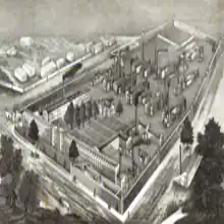

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.134, 0.143] μ=-0.000 σ=0.051 cuda:0
Results: [['The main part of the excavations took place in the royal sector, in the east of the city. A water temple, interpreted as an Anahita temple, was erected near the palace. In the center there is a cross-shaped space with eight large square exedrae decorated with 64 alcoves. The French excavators believed it had been covered with a dome roof, but this reconstruction has been rejected. To the west lies a courtyard decorated with mosaics; to the east, a square iwan used as a reception room. Its walls must have been covered with small stucco ornaments: rows of medallions, bands of foliage, and topped with merlons inherited from Achaemenid architecture. All these decorative techniques were still used after the Islamic conquest of Persia.', 'Although some scholars have asserted that the iwan form may have developed under the Seleucids, today most scholars agree that the Parthians were the inventors of th

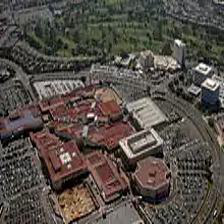

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.166, 0.226] μ=0.001 σ=0.051 cuda:0
Results: [['In the past the network showed some Marshall University and West Virginia University sports content, but has abandoned this practice due to Conference USA/Big 12 exclusivity agreements with commercial and cable outlets.', 'In the past the network showed some Marshall University and West Virginia University sports content, but has abandoned this practice due to Conference USA/Big 12 exclusivity agreements with commercial and cable outlets.', 'In the past the network showed some Marshall University and West Virginia University sports content, but has abandoned this practice due to Conference USA/Big 12 exclusivity agreements with commercial and cable outlets.', 'In the past the network showed some Marshall University and West Virginia University sports content, but has abandoned this practice due to Conference USA/Big 12 exclusivity agreements with commercial and cable outlets.', 'In March 1991, of

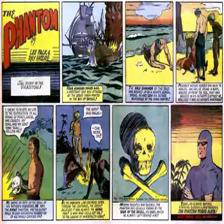

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.192, 0.141] μ=0.001 σ=0.051 cuda:0
Results: [['Sinnott did one additional Kirby pre-superhero Marvel story, "I Was a Decoy for Pildorr: The Plunderer from Outer Space", in Strange Tales #94 (March 1962), before inking his first Marvel superhero comic: both the cover and the interior of penciler Kirby\'s The Fantastic Four #5 (July 1962), the issue introducing the long-running supervillain Dr. Doom. Sinnott also inked a few panels of the following issue\'s second page, the remainder inked by another Kirby regular, Dick Ayers.', "Issue #4 (May 1962) reintroduced Namor the Sub-Mariner, an aquatic antihero who was a star character of Marvel's earliest iteration, Timely Comics, during the late 1930s and 1940s period that historians and fans call the Golden Age of Comics. Issue #5 (July 1962) introduced the team's most frequent nemesis, Doctor Doom. These earliest issues were published bimonthly. With issue #16 (July 1963), the cover title dropped 

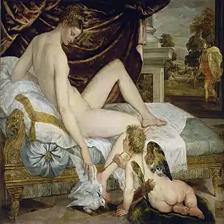

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.155, 0.148] μ=0.002 σ=0.051 cuda:0
Results: [["In the later nineteenth century, academic painters continued with classical themes, but were challenged by the Impressionists. While the composition is compared to Titian and Giogione, Ã\x89douard Manet shocked the public of his time by painting nude women in contemporary situation in his Le DÃ©jeuner sur l'herbe (1863); and although the pose of his Olympia (1865) is said to derive from the Venus of Urbino by Titian, the public saw a prostitute. Gustave Courbet similarly earned criticism for portraying in his Woman with a Parrot a naked prostitute without vestige of goddess or nymph.", "An early imitator of Giorgione was Titian, whose Venus of Urbino (1538) and Pardo Venus (or Jupiter and Antiope, 1534â\x80\x931540) reproduce the same posture as the Sleeping Venus, acquiring, however, greater fame. In Sacred and Profane Love (1514â\x80\x931515) he captured the myth of Plato's Symposium of the

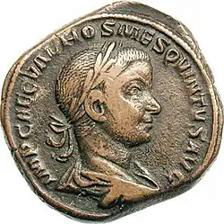

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.189, 0.165] μ=0.002 σ=0.051 cuda:0
Results: [['As an officially recognised coin provided by the Principate, Augustus\' idealised image of himself was imbued throughout the currency. These were also known as imperial coins which have been used as a method to estimate how the emperor intended to see themselves. In this way, the emperor decided how he would be portrayed in contrast to the "biased representation of the historian". His most notable coin, Augustus continuing with his image as the avenging son, designed his coins with the phrase DIVI FILIUS, also known as son of the divine to pay homage to his adoptive father Julius Caesar.', "The coin remained in regular issue under Heraclius's successor Constans II (r. 641â\x80\x93668), from whose reign many specimens survive, but becomes rarer for Constantine IV (r. 668â\x80\x93685), and thereafter seems to have been only occasionally minted as a ceremonial coin until Theodosius III (r. 715â\x

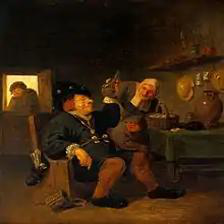

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.167, 0.155] μ=-0.001 σ=0.051 cuda:0
Results: [['The scene is a commentary on the excesses and indulgences of Dutch society in the 17th century, a time of great wealth and prosperity for the Dutch Republic. Jan Steen was known for his humorous and satirical paintings, which often mocked the behavior and attitudes of the Dutch bourgeoisie. Beware of Luxury is no exception, as it pokes fun at the self-indulgent and frivolous lifestyle of the wealthy.', 'Portrait painting thrived in the Netherlands in the 17th century, as there was a large mercantile class who were far more ready to commission portraits than their equivalents in other countries; a summary of various estimates of total production arrives at between 750,000 and 1,100,000 portraits. Rembrandt enjoyed his greatest period of financial success as a young Amsterdam portraitist, but like other artists, grew rather bored with painting commissioned portraits of burghers: "artists travel al

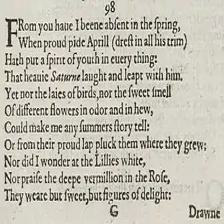

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.163, 0.141] μ=0.001 σ=0.051 cuda:0
Results: [['In Shakespeare\'s early comedies, the sonnets and sonnet-making of his characters are often objects of satire. In Two Gentlemen of Verona, sonnet-writing is portrayed cynically as a seduction technique. In Love\'s Labour\'s Lost, sonnets are portrayed as evidence that love can render men weak and foolish. In Much Ado About Nothing, Beatrice and Benedick each write a sonnet, which serves as proof that they have fallen in love. In Allâ\x80\x99s Well that Ends Well, a partial sonnet is read, and Bertram comments, "He shall be whipp\'d through the army with this rhyme in\'s forehead." In Henry V, the Dauphin suggests he will compose a sonnet to his horse.', 'This poem was published as an appendix to Shakespeare\'s sonnets in 1609. Its authorship has been disputed by several scholars. In 2007 Brian Vickers, in his monograph, Shakespeare, "A Lover\'s Complaint", and John Davies of Hereford, attributes

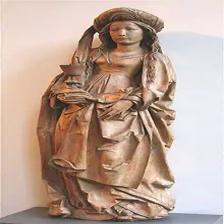

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.159, 0.140] μ=0.000 σ=0.051 cuda:0
Results: [['Its style is associated with the court of Edward I of England, especially in it monumentality, the Virgins\' facial type, and the cascading folds of drapery. It was created near the height of the late medieval cult of the Virgin, and in keeping emphasises her humanity, warmth and accessibility; in particular she turns slightly to her left to face her son. It is a rare English example of this type, similar contemporary statuettes are more common in French art. Yet it is of the highest quality; the art historian William Wixom wrote that "the face is exquisitely rendered, the slight twist of the figure is subtle and eloquent, as the Virgin turns to the Child, and the deep drapery folds, some paper thin, are controlled and elegant".', "Avery suggests a now lost ancient Roman figure of a Bathing Venus as a possible source, one he identifies in a drawing showing three points of view, made by Maarten va

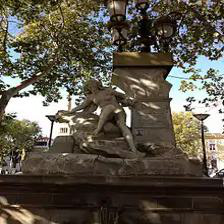

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.131, 0.195] μ=0.001 σ=0.051 cuda:0
Results: [['Boy and His Dog Sculpture or Storrow Memorial is a 1923 statue by Cyrus Dallin, located in a prominent location in Lincoln Cemetery. It portrays a young man bending down to pick a flower with a dog gazing up into his visage. It was created at the request of Helen Osborne Storrow as a memorial to her husband James Jackson Storrow. The Storrows are interred 30 feet north of the monument across a small road in a grave overlooking a picturesque pond.', 'A statue of James A. Garfield by Charles Henry Niehaus stands in Piatt Park, Cincinnati, Ohio, United States.', "A statue of Gilbert du Motier, Marquis de Lafayette is installed in Los Angeles' Lafayette Park, in the U.S. state of California. The sculpture was installed at the park's Wilshire Boulevard entrance in 1937.", "An equestrian statue of JosÃ© de San MartÃ\xadn by Louis-Joseph Daumas is installed in Manhattan's Central Park, in the U.S. sta

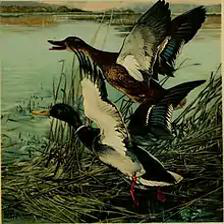

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.182, 0.148] μ=0.002 σ=0.051 cuda:0
Results: [["Porter became interested in colour photography after a publisher rejected a proposal for a book on birds because black and white images wouldn't clearly differentiate the species. Porter began working with a new color film, Kodachrome, introduced in 1935, but it presented considerable technical challenges, especially for capturing fast-moving birds. Drawing on his chemical engineering and research background Porter experimented extensively until he was able to produce satisfactory images. His bird photographs were exhibited in 1943, the first ever exhibition of color photographs at the Museum of Modern Art, New York. His book American Birds: 10 Photographs in Color was published in 1953. His solo exhibition at Limelight Gallery, NYC., March 21-April 17 1955 was effectively a retrospective of this work.", 'Resolved to publish a collection of illustrations of all the birds of North America, Wilson 

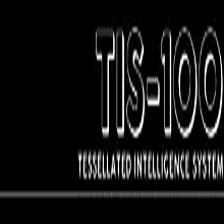

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.143, 0.212] μ=0.000 σ=0.051 cuda:0
Results: [['The logo of Wikipedia is a puzzle globe depicting glyphs from many different writing systems.', 'Each Wikipedia project has a code, which is used as a subdomain of wikipedia.org. The codes mostly conform to ISO 639-1 two-letter codes or ISO 639-3 three-letter codes, with preference given to a two-letter code if available. For example, en stands for English in ISO 639-1, so the English Wikipedia is at en.wikipedia.org.', 'Each Wikipedia project has a code, which is used as a subdomain of wikipedia.org. The codes mostly conform to ISO 639-1 two-letter codes or ISO 639-3 three-letter codes, with preference given to a two-letter code if available. For example, en stands for English in ISO 639-1, so the English Wikipedia is at en.wikipedia.org.', 'Each Wikipedia project has a code, which is used as a subdomain of wikipedia.org. The codes mostly conform to ISO 639-1 two-letter codes or ISO 639-3 three-

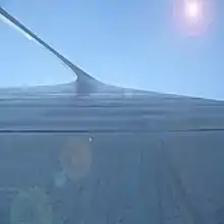

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.163, 0.154] μ=0.001 σ=0.051 cuda:0
Results: [['Several effects of surface tension can be seen with ordinary water:', 'Surface tension is visible in other common phenomena, especially when surfactants are used to decrease it:', 'The process may cause further problems if freezing is involved. Condensed water expands when frozen, possibly causing further structural damage.', 'As the surfactants are absorbed, the solidâ\x80\x93vapor surface tension increases and the edges of the drop become hydrophilic. As a result, the drop spreads.', 'Liquid forms drops because it exhibits surface tension.', 'The same surface tension demonstration can be done with water, lime water or even saline, but only on a surface made of a substance to which water does not adhere. Wax is such a substance. Water poured onto a smooth, flat, horizontal wax surface, say a waxed sheet of glass, will behave similarly to the mercury poured onto glass.', 'The surface tension of 

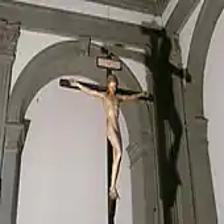

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.141, 0.163] μ=0.001 σ=0.051 cuda:0
Results: [['Andrew Graham-Dixon notes that apart from the wound, Christ\'s "body is as perfectly sculpted and as blemish-free as that of an antique statue. But there are touches of intense humanity about him too: the unidealised, almost coarse-featured face; and those three folds of skin that wrinkle at his belly as he raises his left leg. Piero emphasises his twofold nature, as both man and God."', "Under the ciborium of Arnoldo di Cambio that shelters the main altar is a glass case enclosing the white marble sculpture of St. Cecilia (1600) by the late-Renaissance sculptor Stefano Maderno. A marble slab in the pavement in front of the case quotes Maderno's sworn statement that he has recorded the body as he saw it when the tomb was opened in 1599. The statue depicts the three axe strokes described in the 5th-century account of her martyrdom. It also underscores the incorruptibility of her cadaver (an attrib

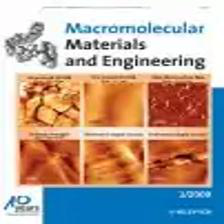

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.197, 0.134] μ=0.002 σ=0.051 cuda:0
Results: [['The journal covers computational materials science including properties, structure, and behavior of all classes of materials at scales from the atomic to the macroscopic. This includes electronic structure/properties of materials determined by ab initio and/or semi-empirical methods, atomic level properties of materials, microstructural level phenomena, continuum-level modelling pertaining to material behaviour, and modelling behaviour in service. Mechanical, microstructural, electronic, chemical, biological, and optical properties of materials are also of interest.', 'Materials Science and Engineering may refer to several journals in the field of materials science and engineering:', 'This is a list of scientific journals in materials science.', 'The Journal of Materials Engineering and Performance is a monthly peer-reviewed scientific journal published by Springer Science+Business Media on behal

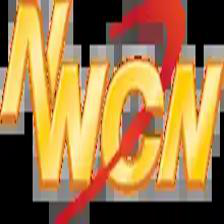

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.170, 0.162] μ=0.001 σ=0.051 cuda:0
Results: [["WHIH Newsfront is a faux American current affairs digital series serving as the center of several viral marketing campaigns for Marvel Studios. Based on the fictional television network WHIH World News that appears throughout the Marvel Cinematic Universe (MCU), the YouTube videos began as marketing for the film Ant-Man, and deal with major events depicted in the MCU's films and television series. The videos were created by Marvel Studios in partnership with Google.", 'Livestreaming playing of video games gained popularity during the 2010s. David M. Ewalt referred to Twitch as "the ESPN of video games". The website spawned from and grew to overshadow Justin.tv, and was purchased by Amazon.com at the end of 2014 for US$970 million. As one of the leading livestreaming platform, Twitch now have millions broadcasters and have nearly two hundreds millions viewers. Other video-game oriented streaming w

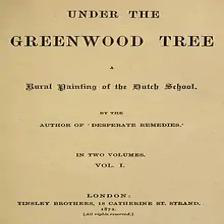

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.162, 0.130] μ=0.002 σ=0.051 cuda:0
Results: [["The first major works about forestry in the English language included Roger Taverner's Booke of Survey (1565), John Manwood's A Brefe Collection of the Lawes of the Forrest (1592) and John Evelyn's Sylva (1662).", 'In 2021, Graywolf Press published The Trees, a satirical novel about historic and contemporary lynchings in Mississippi, the South and across the US. (It was published in the UK by Influx Press). It won the Anisfield-Wolf Book Award and was shortlisted for the 2022 Booker Prize.', 'The Journal of Forestry commenced publication in 1917, incorporating the Quarterly and the Proceedings of the Society of American Foresters. Volume was set at 15, continuing the Quarterly number system. Editorial responsibilities were assumed by the editorial board of the Society of American Foresters, for which the Journal became the official publication.', 'English Botany was a major publication of British

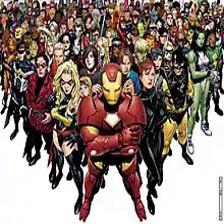

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.145, 0.181] μ=0.001 σ=0.051 cuda:0
Results: [["During the Infinity, Luke Cage is shown leading a new Heroes for Hire roster consisting of himself, White Tiger and Power Man. The team dissolves after White Tiger quits when the Superior Spider-Man (Doctor Octopus' mind in Peter Parker's body) considered the team mercenaries following a fight with Plunderer. The remnants of the group go on to form the new Mighty Avengers during Thanos's invasion of Earth.", 'In March 2010, Marvel announced the series would be relaunched in June as part of the company\'s rebranding initiative, "Heroic Age" . In the first issue of the series, the new team consisted of Luke Cage, Victoria Hand, Iron Fist, Jessica Jones, Mockingbird, Ms. Marvel, Spider-Man, The Thing, and Wolverine. Wolverine and Spider-Man operated on the main Avengers team as well as the New Avengers, and Doctor Strange accepted an offer to join the team after their first mission while searching f

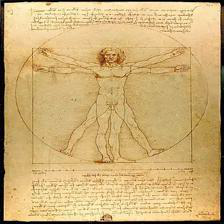

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.145, 0.191] μ=0.002 σ=0.051 cuda:0
Results: [['The early writers discussed here treated vision more as a geometrical than as a physical, physiological, or psychological problem. The first known author of a treatise on geometrical optics was the geometer Euclid (c. 325 BCâ\x80\x93265 BC). Euclid began his study of optics as he began his study of geometry, with a set of self-evident axioms.', 'Leaving the technical optical arguments aside, historians of science investigated several aspects of the historical plausibility of the thesis in a 2005 set of articles in Early Science and Medicine. In his introduction to the volume, Sven DuprÃ© claimed the Hockneyâ\x80\x93Falco analysis rests heavily on a small number of examples, "a few dozen square centimeters" of canvas that seem to show signs that optical devices were used.', 'Many contemporary scientists, such as Gassendi, dispute Galileo\'s methodology for conceptualizing his law of falling bod

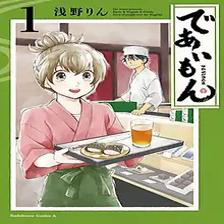

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.134, 0.129] μ=0.002 σ=0.051 cuda:0
Results: [['A 2-volume manga spin-off published by Hirari Comics was released on April 30, 2015. The first volume, Another Yuritopia (ã\x82\x82ã\x81\x86ã\x812ã\x81 ̈ã\x81¤ã\x81®ã\x83¦ã\x83aã\x83\x88ã\x83\x94ã\x82¢, Mou Hitotsu no Yuritopia) was written and illustrated by Hachi ItÅ\x8d, while the second volume, Friendship Quiz (ä»2è\x89 ̄ã\x81\x97ã\x82 ̄ã\x82¤ã\x82o, Nakayoshi Kuizu), was written by Toi Tentsu and illustrated by Aya Fumio. The manga was licensed by Seven Seas Entertainment who released it in English as a single omnibus volume on January 31, 2017. The manga takes place after the events of the game and focus on new characters who were not in the original visual novel, alongside returning characters.', 'A manga version of the novel has also been written by Makoto Shinkai and illustrated by Ranmaru Kotone. The manga was licensed by Yen Press for an English release, with the firs

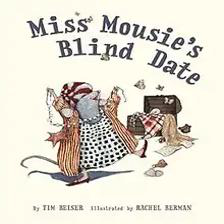

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.128, 0.166] μ=0.002 σ=0.051 cuda:0
Results: [['The first cartoon in the series, Poor Cinderella, featured Betty Boop (with red hair and turquoise eyes); future shorts usually did not have familiar or recurring characters.', 'Within a year, Betty made the transition from an incidental human-canine breed to a completely human female character. While much credit has been given to Grim Natwick for helping to transform Max Fleischer\'s creation, her transition into the cute cartoon girl was also in part due to the work of Bernard Wolf, Otto Feuer, Seymour Kneitel, Roland "Doc" Crandall, Willard Bowsky, and James "Shamus" Culhane. By the release of Any Rags, Betty Boop was forever established as a human character. Her floppy poodle ears became hoop earrings, and her black poodle nose became a girl\'s button-like nose.', 'Within a year, Betty made the transition from an incidental human-canine breed to a completely human female character. While much

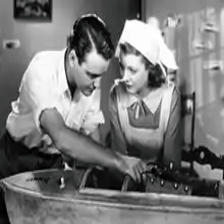

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.187, 0.162] μ=0.000 σ=0.051 cuda:0
Results: [['American mystery film series of the 1930s predominantly relied on mystery literature for inspiration. About every character from the 1930s drew from literature, such as Charlie Chan, Nick and Nora Charles, Thatcher Colt, Perry Mason, and Mr. Wong. The 1930s featured many female detectives of various ages from Nancy Drew, Torchy Blane and Hildegarde Withers while the 1940s had none. Productions in the 1930s were occasionally A-budget pictures such as The Black Camel (1931), Aresene Lupin (1932) and The Thin Man (1934).', 'By 1950, the film industry was under total government control, plans for new movies were only issued by central command (with themes like "socialist conversion of the agriculture", or "exposing enemy sabotage".) The films were issued to be directed by industry veterans who started their career in the 1930-40s, like Frigyes BÃ¡n or MÃ¡rton Keleti, even while they were politicall

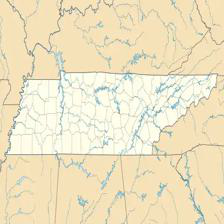

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.182, 0.145] μ=2.512e-05 σ=0.051 cuda:0
Results: [['It was listed on the National Register of Historic Places in 1979. It is located in the Lewisburg Historic District.', 'He lives on a 1793 farm in Brentwood, Tennessee, which is listed on the National Register of Historic Places.', 'The Anderson Lumber Company property, roughly bounded by Brown, First, and Holland Streets in Philipsburg, Montana, was listed on the National Register of Historic Places in 1986.', 'He lives in a 1793 farm house in Brentwood, Tennessee, which is listed on the National Register of Historic Places.', 'Gardner Farmstead, on Licking Station Rd. near Salyersville, Kentucky was listed on the National Register of Historic Places in 2015.', 'It was listed on the National Register of Historic Places in 1982. It is located in the Richlands Historic District.', 'Cooper resided in Denver, Colorado, as well as Illinois and Iowa. In 1905 she married Nathan M. Hubbard and moved

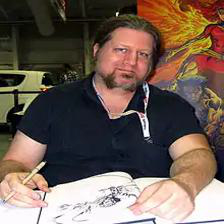

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.145, 0.156] μ=0.002 σ=0.051 cuda:0
Results: [['He has drawn comics for many publishers, starting in the mid-1980s. He has done work for several small press companies, on titles like The Hero Alliance and Evangeline. For DC Comics, he has done art on Manhunter, Superman, and others. In the early 1990s, for Malibu Comics, he illustrated The Solution and Prime. For Marvel Comics, he did art on Avengers Unplugged and G.I. Joe. He also worked for First Comics on Evangeline and GrimJack.', 'As a comic book inker he has worked with other artists on Marvel Comics books such as Daredevil, the Earth X trilogy, The Hulk, and The Amazing Spider-Man. At DC Comics he has done inking on comic series Challengers of the Unknown, The Book Of Fate, Batman, Green Arrow, and Brave And The Bold.', 'He has done illustration work for RPG companies like Wizards of the Coast, Hogshead Publishing and Guardians of Order, as well as small press publications like The End 

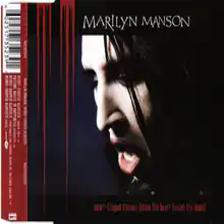

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.144, 0.143] μ=0.001 σ=0.051 cuda:0
Results: [['The Woman in Me is the second studio album by Canadian country singer-songwriter Shania Twain and her first to be produced by long-time collaborator and then-husband Robert John "Mutt" Lange. Released on February 7, 1995, it went on to become her biggest-selling recording at the time, selling 4 million copies by the end of the year, and was eventually certified 12Ã\x97 Platinum by the RIAA on December 1, 2000, for 12 million shipments throughout the United States. The album has sold an estimated 20 million copies worldwide. It was ranked number 8 on CMT\'s list of 40 Greatest Albums in Country Music in 2006. The album is credited with having influenced the sound of contemporary country music. Eight singles were released from the album for its promotion, including "Whose Bed Have Your Boots Been Under?", "Any Man of Mine", "(If You\'re Not in It for Love) I\'m Outta Here!" and "You Win My Love", 

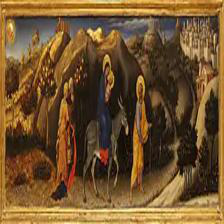

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.137, 0.205] μ=0.001 σ=0.051 cuda:0
Results: [['Three pictures by him are in the Museo del Prado. They did not enter the royal collection until the 18th century, through the collection of Charles IV. At least two of them are dated 1649, suggesting a presence of his work in Spain since the 17th century. In these three canvases he shows his knowledge of southern European painting, both in the Italianization of some details and in certain loans from the work of Claude Lorrain and hints of the Battle of Ostia by Raphael. These traits are visible in the Naval Battle between Turks and Maltese.', "Archduke Leopold Wilhelm and the artist in the archducal picture gallery in Brussels is a 1653 painting of Archduke Leopold Wilhelm's Italian art collection by the Flemish Baroque painter David Teniers the Younger, now held in the collection of Museo LÃ¡zaro Galdiano in Madrid.", 'Along with The Triumph of Bacchus, Saint Joseph, and Saint Joachim Reading a

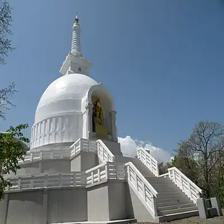

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.177, 0.161] μ=0.001 σ=0.051 cuda:0
Results: [['The architecture of Buddhist temples, as that of any structure, has changed and developed over the centuries. However, while the particular details may vary, the general themes and styles have strong similarities and common origins.', 'A Buddhist temple or Buddhist monastery is the place of worship for Buddhists, the followers of Buddhism. They include the structures called vihara, chaitya, stupa, wat and pagoda in different regions and languages. Temples in Buddhism represent the pure land or pure environment of a Buddha. Traditional Buddhist temples are designed to inspire inner and outer peace.', 'One temple has been converted to Hindu use as the Dharma Mahakala temple; this was built over an earlier stupa, and was moved to the side of the site and re-erected by the ASI. It contains a Buddhist standing relief figure of Manjushri. The later parts date to the 11th century.', "Similarities betwee

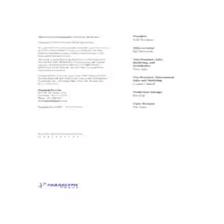

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.178, 0.196] μ=0.001 σ=0.051 cuda:0
Results: [['The leaked document includes the following proposals:', 'Various other texts are also bundled into the Corpus, including:', 'Reactions included an Open Letter, signed by more than 1790 researchers, expressing their concerns about perceived unintended outcomes of the Plan if implemented as stated before the publication of the specific implementation guidance. Another Open Letter in support of mandatory open access was issued after the publication of the specific implementation guide, and had been signed by over 1,900 researchers by the end of 2018. However, it did not reference Plan S specifically.', 'A program of digitization of the archive had by 2008 scanned 1 million documents to be stored in digital format with the aim of making them available online. In 2012, the Archives inaugurated the "Documentation on the Web" initiative which provides online access to items in its collections. Israel\'s

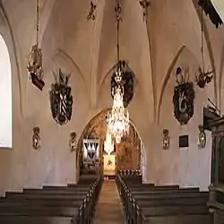

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.144, 0.249] μ=0.000 σ=0.051 cuda:0
Results: [['The Abbey Church of St. Gall, Switzerland, shows the plan that was to become common throughout Germanic Europe. It is a Latin Cross with a comparatively long nave and short transepts and eastern end, which is apsidal. The nave is aisled, but the chancel and transepts are not. It has an apsidal west end, which was to become a feature of Churches of Germany, such as Worms Cathedral. Speyer Cathedral, Germany, also has aisleless transept and chancel. It has a markedly modular look. A typical Germanic characteristic is the presence of towers framing the chancel and the west end. There is marked emphasis on the western entrance, called Westwerk, which is seen in several other churches. Each vault compartment covers two narrow bays of the nave', 'The old Roman custom of having the altar at the west end and the entrance at the east was sometimes followed as late as the 11th century even in areas under F

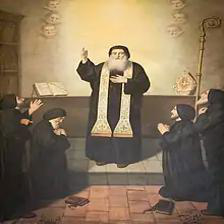

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.169, 0.147] μ=-0.000 σ=0.051 cuda:0
Results: [['To the same period belongs the "Summa de arte prÃ¦dicatoriÃ¢" by Alain de Lille, which defines preaching: "Manifesta et publica instructio morum et fidei, informationi hominum deserviens, ex rationum semitÃ¢ et auctoritatum fonte proveniens". He lays stress on explanation and use of Scripture and recommends the preacher to insert verba commotiva. The remarks of CÃ¦sarius of Heisterbach (died 1240) have been collected by Cruel; his sermons display skill in construction and considerable oratorical power. Conrad of Brundelsheim (died 1321), whose sermons have come down to us under his cognomen of "Brother Sock" (Sermones Fratris Socci), was one of the most interesting preachers at this time in Germany. Humbert of Romans, General superior of the Dominicans, in the second book of his work, "De eruditione prÃ¦dicatorum", claims that he can teach "a way of promptly producing a sermon for any set o

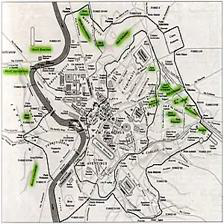

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.127, 0.154] μ=0.000 σ=0.051 cuda:0
Results: [['The Romans used a consolidated scheme for city planning, developed for military defense and civil convenience. The basic plan consisted of a central forum with city services, surrounded by a compact, rectilinear grid of streets, and wrapped in a wall for defense. To reduce travel times, two diagonal streets crossed the square grid, passing through the central square. A river usually flowed through the city, providing water, transport, and sewage disposal. Hundreds of towns and cities were built by the Romans throughout their Empire.', 'The ancient Romans also used orthogonal plans for their cities. City planning in the Roman world was developed for military defense and public convenience. The spread of the Roman Empire subsequently spread the ideas of urban planning. As the Roman Empire declined, these ideas slowly disappeared. However, many cities in Europe still held onto the planned Roman city

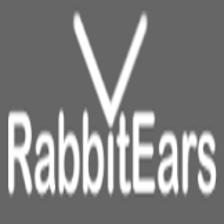

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.153, 0.124] μ=-6.089e-05 σ=0.051 cuda:0
Results: [["The malware's primary attack vector is repackaging legitimate Android applications (e.g. Facebook, Twitter, WhatsApp, Candy Crush, Google Now, Snapchat) with adware included. The app which remains functional is then released to a third party app store; once downloaded, the application generates revenue by serving ads (estimated to amount to $2 US per installation), most users cannot get rid of the virus without getting a new device, as the only other way to get rid of the malware is to root affected devices and re-flash a custom ROM.", "Gumblar is a malicious JavaScript trojan horse file that redirects a user's Google searches, and then installs rogue security software. Also known as Troj/JSRedir-R this botnet first appeared in 2009.", 'The bot itself is spread through the ZeroAccess rootkit through a variety of attack vectors. One attack vector is a form of social engineering, where a user 

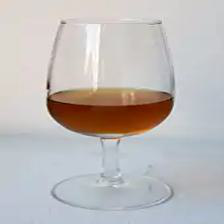

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.144, 0.168] μ=0.001 σ=0.051 cuda:0
Results: [['Vermouth is the most widely used aromatised wine due to its use in cocktails and famous commercial brands such as Martini and Cinzano which are commonplace around the world. Vermouth can be sweet or dry and red, white, pink or orange. It is traditionally flavoured with an infusion of herbs, peels and spices, including wormwood but modern commercial brands are likely to be made with a sweet concentrate of flavours to maintain consistency and low-cost. Other brands include Punt e Mes, Noilly Prat and Carpano.', "Other similar beverages described in this legislation are 'aromatised wine-based drinks' (non-fortified) and 'aromatised wine-product cocktail' (blended, lower alcohol drink under 7% ABV).", 'In Bulgaria, it is called greyano vino (Bulgarian: Ð3Ñ\x80ÐμÑ\x8fÐ1⁄2Ð3⁄4 Ð2Ð ̧Ð1⁄2Ð3⁄4; "heated wine"), and consists of red wine, honey and peppercorn. Sometimes apples or citrus fruits, such as lem

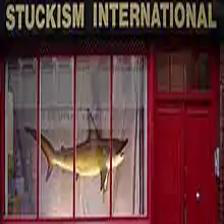

Image embedding: tensor[1, 384] 1.5Kb x∈[-0.148, 0.176] μ=-8.247e-05 σ=0.051 cuda:0
Results: [["Inspired by Frank Perry's film The Swimmer, Sharrocks invited people to 'swim across London from Tooting Bec Lido to Hampstead Heath ponds'. It has been referred to as a 'flesh mobbing'", 'Halifax Alehouse security staff have been involved in various violent incidents. In 2009, a scuffle between photography students and a Halifax Alehouse bouncer on the public sidewalk outside the bar made local news.', 'Similar situations involving super-injunctions in England and Wales have occurred, one involving Jeremy Clarkson. Since January 2016 a celebrity (later revealed outside England and Wales to be David Furnish) used the injunction granted in PJS v News Group Newspapers to prevent media in England and Wales reporting events that have been featured in Scottish media and on the Internet.', "Another conflict involved Jeremy Clarkson, a TV presenter and Top Gear host who lives on the Isle of Man. He

: 

In [11]:
for sample in samples:
    # show tensor as image
    img = sample["image"]
    img = img.permute(1, 2, 0)
    # denormalize
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = (img * 255).byte()
    img = Image.fromarray(img.numpy())
    display(img)
    with torch.no_grad():
        embedding = model(pixel_values=sample["image"].unsqueeze(0).to(device))
    print("Image embedding:", embedding)
    embedding = embedding.squeeze(0).cpu().tolist()
    res = collection.query(query_embeddings=[embedding], n_results=10)
    print("Results:", res["documents"])